# What's  Different?

key point to remember is that though this model give us a clear view of the boundary prediction its not good as pinn
so for better results pinn+bayesian is one way

# Results Summary

## Full(164k)
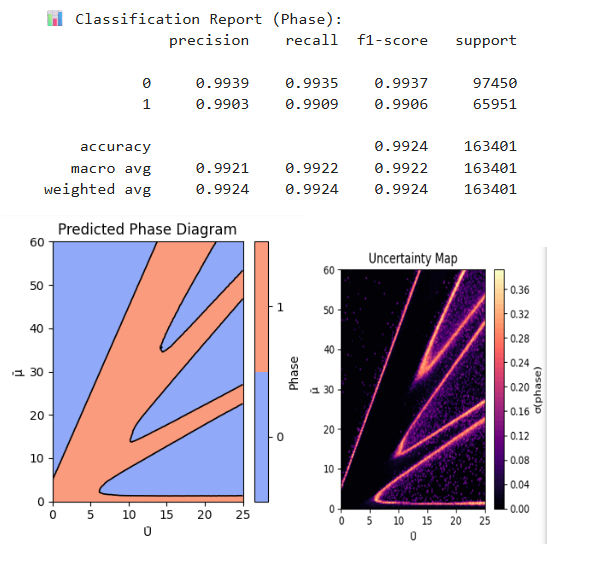
## 10k
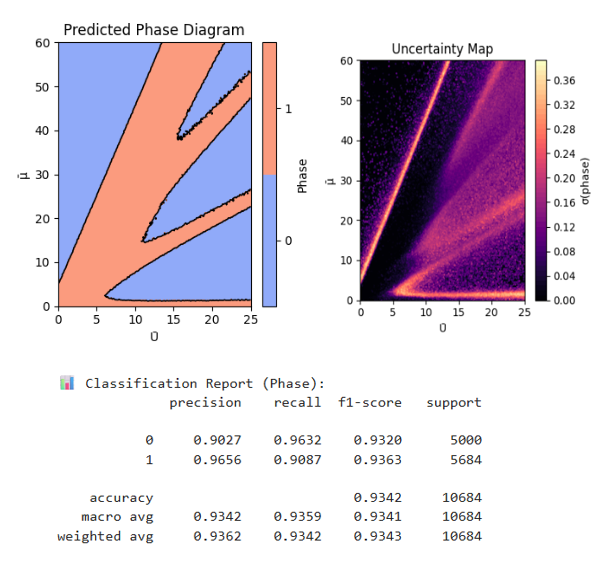
## 6k
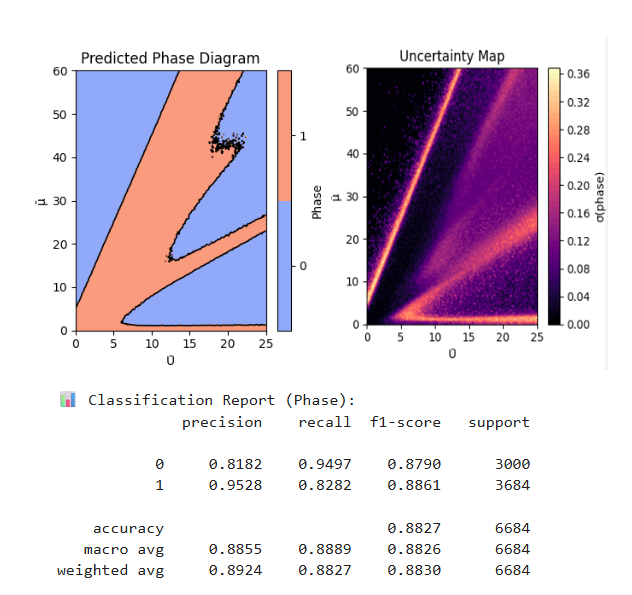
## 4k
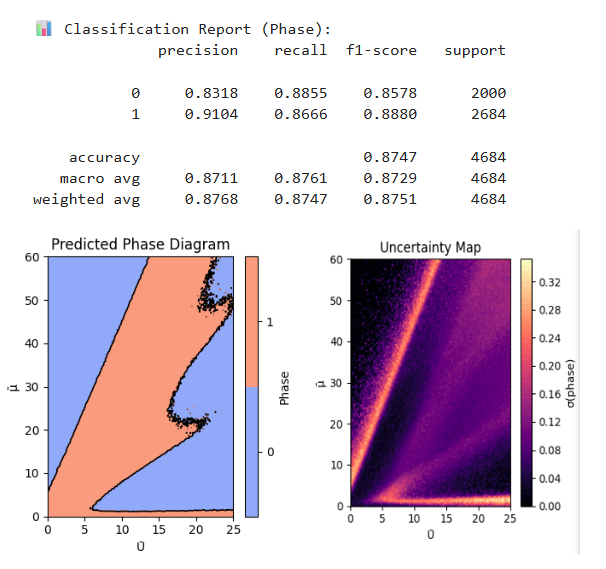

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)
print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}


          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

Epoch 1/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6739 - phase_accuracy: 0.7105 - phase_loss: 0.5682 - phi2_loss: 0.5973 - rho_loss: 1.5071 - val_loss: 0.9688 - val_phase_accuracy: 0.7115 - val_phase_loss: 0.5012 - val_phi2_loss: 0.0835 - val_rho_loss: 0.3859
Epoch 2/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7508 - phase_accuracy: 0.8513 - phase_loss: 0.3149 - phi2_loss: 0.1467 - rho_loss: 0.2891 - val_loss: 0.5564 - val_phase_accuracy: 0.7823 - val_phase_loss: 0.4262 - val_phi2_loss: 0.0708 - val_rho_loss: 0.0606
Epoch 3/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5310 - phase_accuracy: 0.8748 - phase_loss: 0.2521 - phi2_loss: 0.0936 - rho_loss: 0.1852 - val_loss: 0.4793 - val_phase_accuracy: 0.8100 - val_phase_loss: 0.3878 - val_phi2_loss: 0.0630 - val_rho_loss: 0.0297
Epoch 4/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4388 - phase_accuracy: 0.8932 - phase_loss: 0.2189 - phi2_loss: 0.0774 - rho_loss: 0.1425 - val_loss: 0.4048 - val_pha

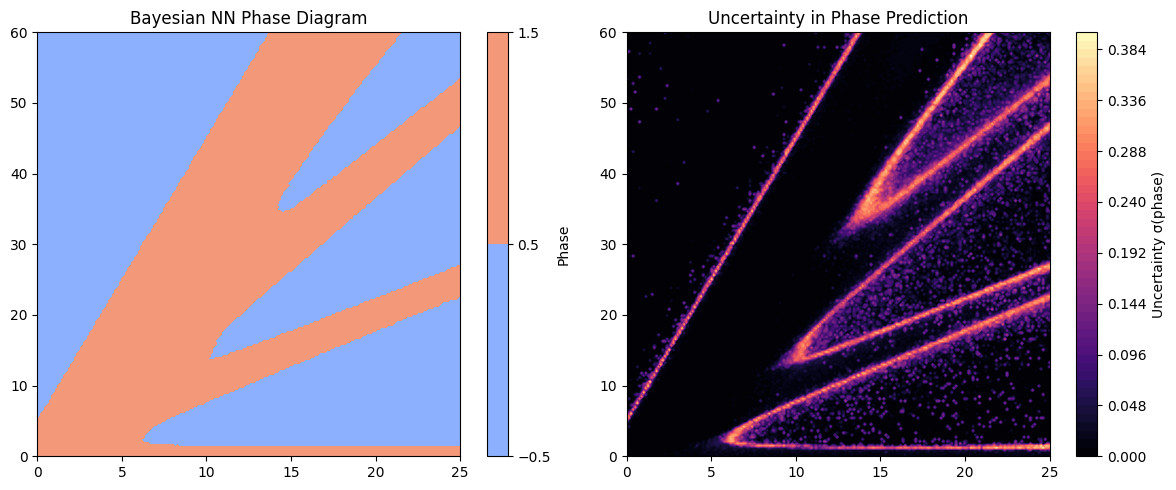

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

# --- 1) Bayesian NN model ---
def make_bayesian_nn(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,), name="input")  # [Ū, M̄]
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # dropout active

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        metrics={"phase":"accuracy"}
    )
    return model

bayes_nn = make_bayesian_nn()

# --- 2) Train ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
}

history = bayes_nn.fit(
    X, y_targets,
    batch_size=256,
    epochs=100,
    validation_split=0.15,
    verbose=1
)

# --- 3) MC Dropout prediction ---
def mc_predict(model, X, n=50):
    preds_phase, preds_phi, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi, p_rho = model(X, training=True)  # keep dropout active
        preds_phase.append(p_phase.numpy())
        preds_phi.append(p_phi.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi, axis=0), np.std(preds_phi, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0)
    )

# --- 4) Phase diagram with uncertainty ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)

plt.figure(figsize=(12,5))

# Phase boundary
plt.subplot(1,2,1)
plt.contourf(UU, MU, (phase_mean>0.5).astype(int), levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(label="Phase")
plt.title("Bayesian NN Phase Diagram")

# Uncertainty map
plt.subplot(1,2,2)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="Uncertainty σ(phase)")
plt.title("Uncertainty in Phase Prediction")

plt.tight_layout()
plt.show()


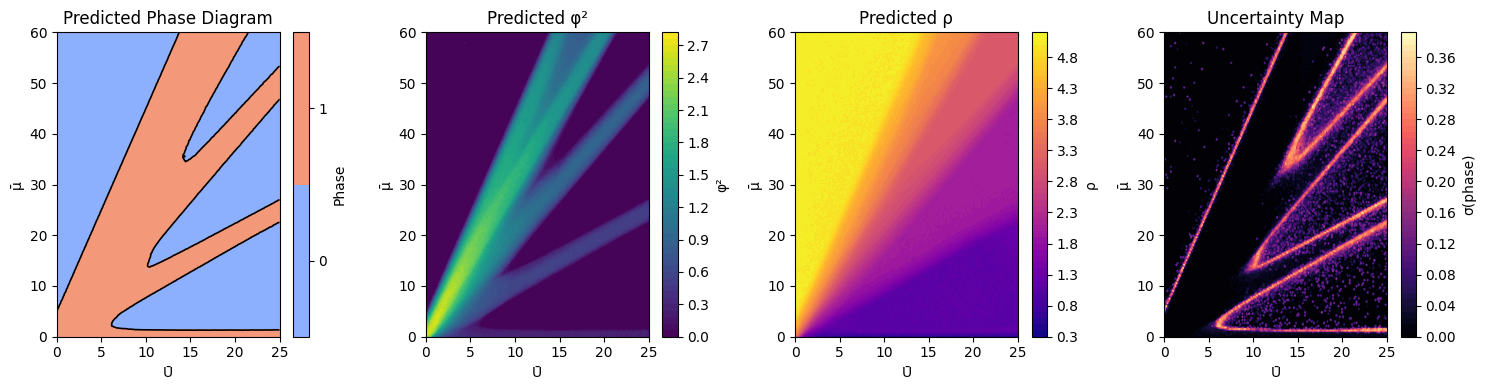

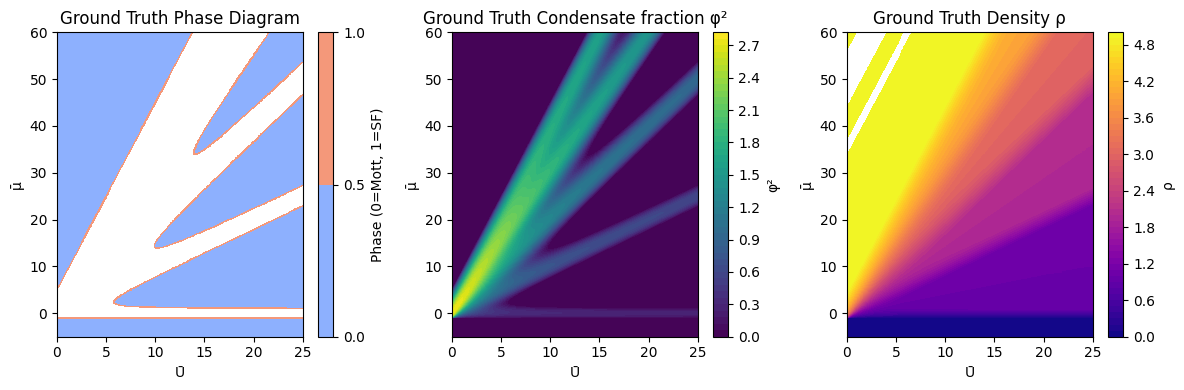


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9939    0.9935    0.9937     97450
           1     0.9903    0.9909    0.9906     65951

    accuracy                         0.9924    163401
   macro avg     0.9921    0.9922    0.9922    163401
weighted avg     0.9924    0.9924    0.9924    163401



C:\Users\DELL\AppData\Local\Temp\ipykernel_13812\4278340516.py:89: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [4]:
# --- 4) Predict on grid with MC dropout ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)

phase_pred_class = (phase_mean > 0.5).astype(int)

# --- 5) Plot Bayesian NN predictions ---
plt.figure(figsize=(15,4))

# Phase
plt.subplot(1,4,1)
plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ²
plt.subplot(1,4,2)
plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ
plt.subplot(1,4,3)
plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Uncertainty
plt.subplot(1,4,4)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Uncertainty Map")

plt.tight_layout()
plt.show()


# --- 6) Ground truth (same as before) ---
plt.figure(figsize=(12,4))
# (phase, phi², rho from dataset)
# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# --- 7) Classification report on training data ---
from sklearn.metrics import classification_report

phase_train_mean, _, _, _, _, _ = mc_predict(bayes_nn, X, n=50)
y_pred_labels = (phase_train_mean > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


# Reduced Datasets 

## 10k dataset

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

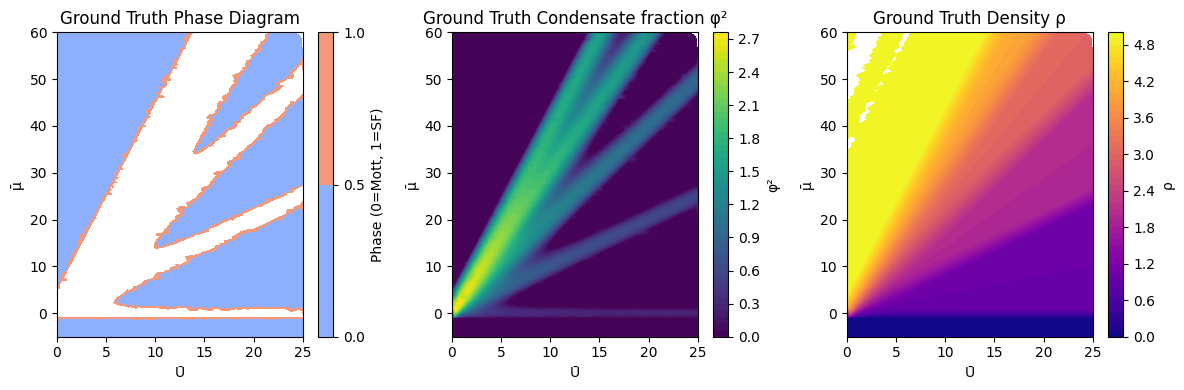

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)
print(df)

# # Features and targets
# X = df[["Ubar","Mubar"]].values.astype(np.float32)
# y = {
#     "phase": df["Phase"].values.astype(np.float32),
#     "phi2": df["Phi2"].values.astype(np.float32),
#     "rho": df["Density"].values.astype(np.float32),
# }
# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(5000, len(df_MI))
n_SF = min(5000, len(df_SF))
n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()



Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 9.3728 - phase_accuracy: 0.5422 - phase_loss: 1.1453 - phi2_loss: 1.2738 - rho_loss: 6.9239 - val_loss: 4.0171 - val_phase_accuracy: 0.3325 - val_phase_loss: 1.0256 - val_phi2_loss: 0.6979 - val_rho_loss: 2.2008
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0600 - phase_accuracy: 0.5900 - phase_loss: 0.8278 - phi2_loss: 0.6615 - rho_loss: 3.5538 - val_loss: 3.0699 - val_phase_accuracy: 0.6831 - val_phase_loss: 0.8122 - val_phi2_loss: 0.6979 - val_rho_loss: 1.4950
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3417 - phase_accuracy: 0.6196 - phase_loss: 0.6963 - phi2_loss: 0.6593 - rho_loss: 1.9854 - val_loss: 3.4929 - val_phase_accuracy: 0.6319 - val_phase_loss: 0.8297 - val_phi2_loss: 0.6979 - val_rho_loss: 1.8774
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9844 - phase_accuracy: 0.6212 - phase_loss: 0.6609 - phi2_loss: 0.6597 - rho_loss: 1.6636 - val_loss: 3.4036 - val_phase_accu

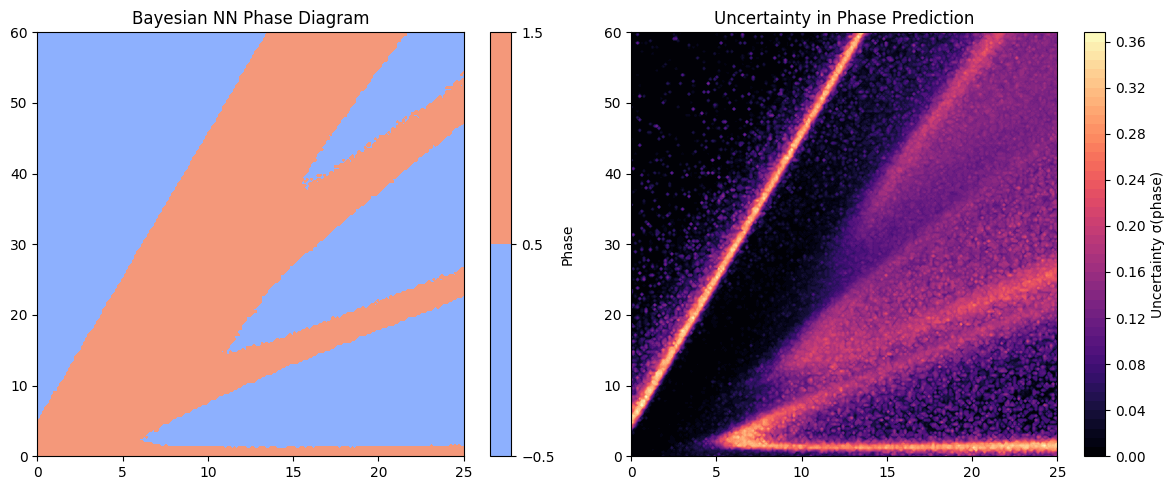

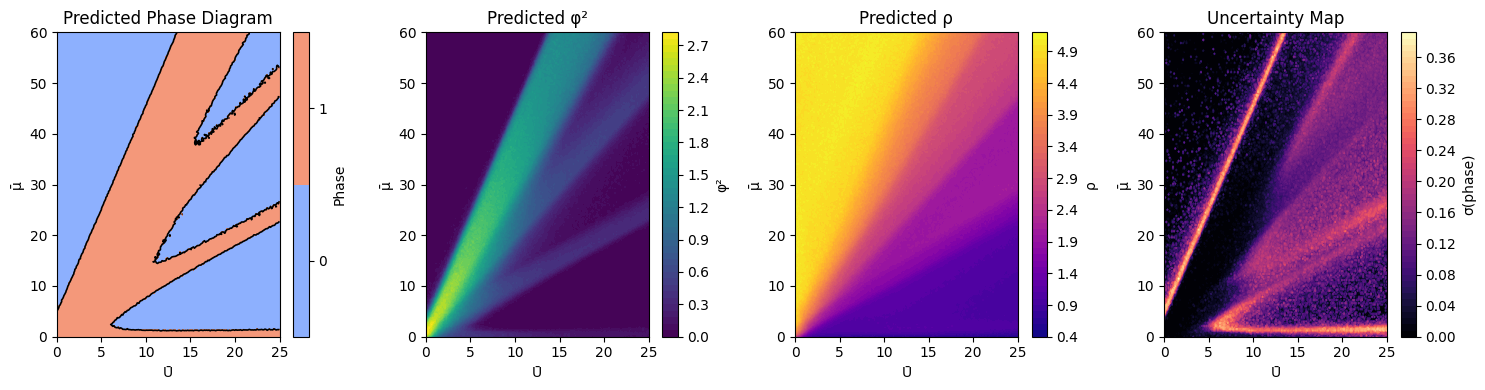

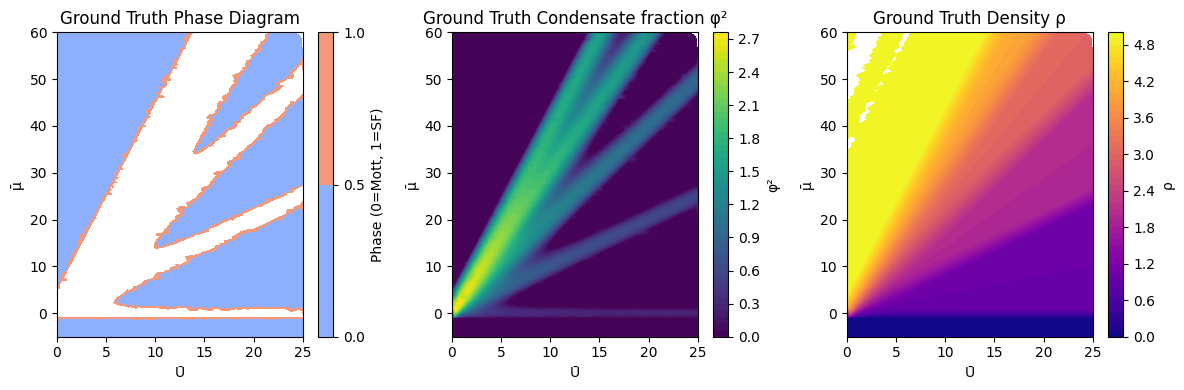


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9027    0.9632    0.9320      5000
           1     0.9656    0.9087    0.9363      5684

    accuracy                         0.9342     10684
   macro avg     0.9342    0.9359    0.9341     10684
weighted avg     0.9362    0.9342    0.9343     10684



C:\Users\DELL\AppData\Local\Temp\ipykernel_13812\2406665172.py:186: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [7]:
# # Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

# --- 1) Bayesian NN model ---
def make_bayesian_nn(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,), name="input")  # [Ū, M̄]
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # dropout active

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        metrics={"phase":"accuracy"}
    )
    return model

bayes_nn = make_bayesian_nn()

# --- 2) Train ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
}

history = bayes_nn.fit(
    X, y_targets,
    batch_size=256,
    epochs=100,
    validation_split=0.15,
    verbose=1
)

# --- 3) MC Dropout prediction ---
def mc_predict(model, X, n=50):
    preds_phase, preds_phi, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi, p_rho = model(X, training=True)  # keep dropout active
        preds_phase.append(p_phase.numpy())
        preds_phi.append(p_phi.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi, axis=0), np.std(preds_phi, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0)
    )

# --- 4) Phase diagram with uncertainty ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)

plt.figure(figsize=(12,5))

# Phase boundary
plt.subplot(1,2,1)
plt.contourf(UU, MU, (phase_mean>0.5).astype(int), levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(label="Phase")
plt.title("Bayesian NN Phase Diagram")

# Uncertainty map
plt.subplot(1,2,2)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="Uncertainty σ(phase)")
plt.title("Uncertainty in Phase Prediction")

plt.tight_layout()
plt.show()

# --- 4) Predict on grid with MC dropout ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)

phase_pred_class = (phase_mean > 0.5).astype(int)

# --- 5) Plot Bayesian NN predictions ---
plt.figure(figsize=(15,4))

# Phase
plt.subplot(1,4,1)
plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ²
plt.subplot(1,4,2)
plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ
plt.subplot(1,4,3)
plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Uncertainty
plt.subplot(1,4,4)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Uncertainty Map")

plt.tight_layout()
plt.show()


# --- 6) Ground truth (same as before) ---
plt.figure(figsize=(12,4))
# (phase, phi², rho from dataset)
# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# --- 7) Classification report on training data ---
from sklearn.metrics import classification_report

phase_train_mean, _, _, _, _, _ = mc_predict(bayes_nn, X, n=50)
y_pred_labels = (phase_train_mean > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


## 6k dataset

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

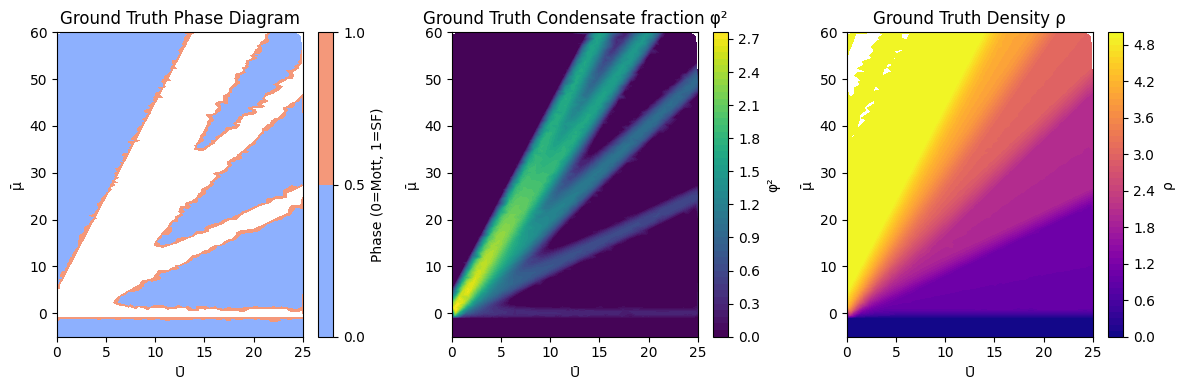

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7443 - phase_accuracy: 0.5367 - phase_loss: 1.3329 - phi2_loss: 0.8510 - rho_loss: 5.4703 - val_loss: 4.6446 - val_phase_accuracy: 0.0000e+00 - val_phase_loss: 1.5906 - val_phi2_loss: 0.4955 - val_rho_loss: 2.5438
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2733 - phase_accuracy: 0.5804 - phase_loss: 0.7898 - phi2_loss: 0.6672 - rho_loss: 2.7676 - val_loss: 3.5508 - val_phase_accuracy: 0.0000e+00 - val_phase_loss: 1.2836 - val_phi2_loss: 0.4955 - val_rho_loss: 1.7583
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4334 - phase_accuracy: 0.5819 - phase_loss: 0.7328 - phi2_loss: 0.6827 - rho_loss: 2.0484 - val_loss: 3.5798 - val_phase_accuracy: 0.2792 - val_phase_loss: 1.0271 - val_phi2_loss: 0.4955 - val_rho_loss: 2.0423
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1063 - phase_accuracy: 0.5985 - phase_loss: 0.6820 - phi2_loss: 0.6638 - rho_loss: 1.7518 - val_loss: 3.4106 - val_ph

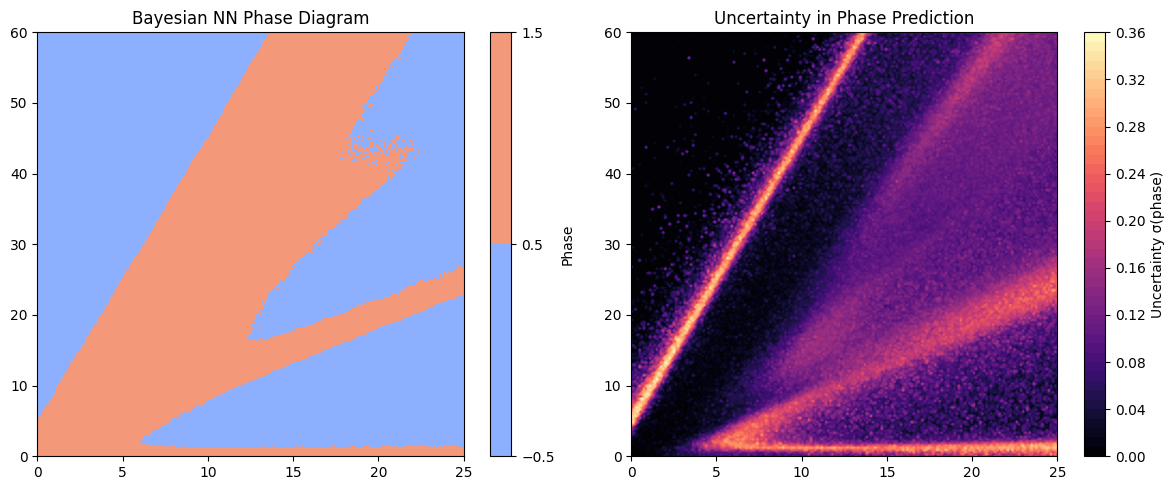

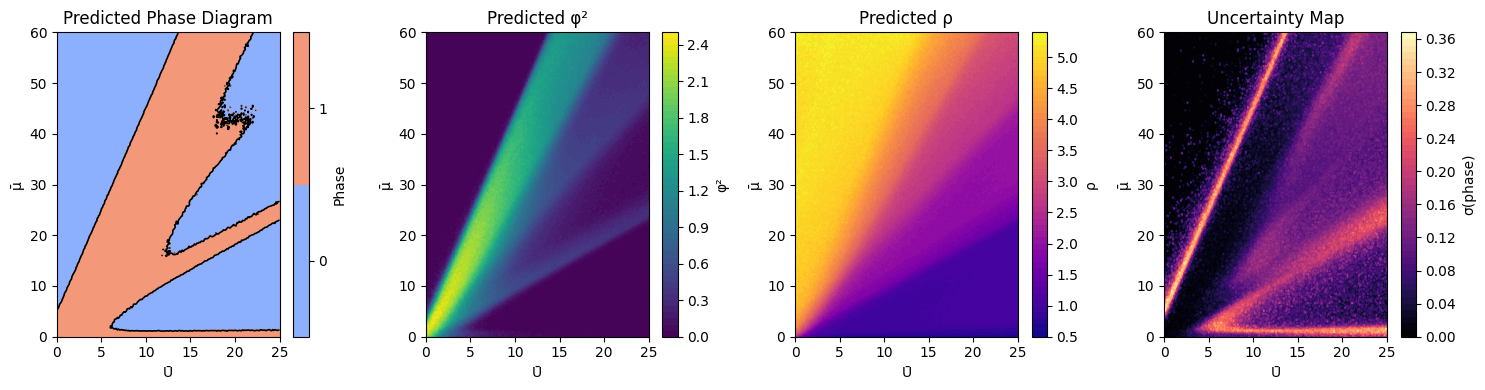

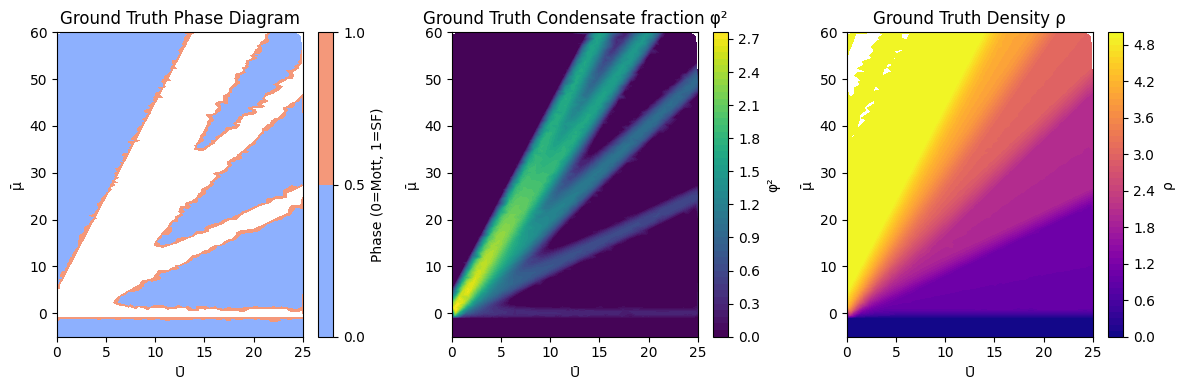


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.8182    0.9497    0.8790      3000
           1     0.9528    0.8282    0.8861      3684

    accuracy                         0.8827      6684
   macro avg     0.8855    0.8889    0.8826      6684
weighted avg     0.8924    0.8827    0.8830      6684



C:\Users\DELL\AppData\Local\Temp\ipykernel_13812\895062011.py:317: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)
print(df)

# # Features and targets
# X = df[["Ubar","Mubar"]].values.astype(np.float32)
# y = {
#     "phase": df["Phase"].values.astype(np.float32),
#     "phi2": df["Phi2"].values.astype(np.float32),
#     "rho": df["Density"].values.astype(np.float32),
# }
# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(3000, len(df_MI))
n_SF = min(3000, len(df_SF))
n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# # Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

# --- 1) Bayesian NN model ---
def make_bayesian_nn(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,), name="input")  # [Ū, M̄]
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # dropout active

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        metrics={"phase":"accuracy"}
    )
    return model

bayes_nn = make_bayesian_nn()

# --- 2) Train ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
}

history = bayes_nn.fit(
    X, y_targets,
    batch_size=256,
    epochs=100,
    validation_split=0.15,
    verbose=1
)

# --- 3) MC Dropout prediction ---
def mc_predict(model, X, n=50):
    preds_phase, preds_phi, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi, p_rho = model(X, training=True)  # keep dropout active
        preds_phase.append(p_phase.numpy())
        preds_phi.append(p_phi.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi, axis=0), np.std(preds_phi, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0)
    )

# --- 4) Phase diagram with uncertainty ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)

plt.figure(figsize=(12,5))

# Phase boundary
plt.subplot(1,2,1)
plt.contourf(UU, MU, (phase_mean>0.5).astype(int), levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(label="Phase")
plt.title("Bayesian NN Phase Diagram")

# Uncertainty map
plt.subplot(1,2,2)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="Uncertainty σ(phase)")
plt.title("Uncertainty in Phase Prediction")

plt.tight_layout()
plt.show()

# --- 4) Predict on grid with MC dropout ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)

phase_pred_class = (phase_mean > 0.5).astype(int)

# --- 5) Plot Bayesian NN predictions ---
plt.figure(figsize=(15,4))

# Phase
plt.subplot(1,4,1)
plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ²
plt.subplot(1,4,2)
plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ
plt.subplot(1,4,3)
plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Uncertainty
plt.subplot(1,4,4)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Uncertainty Map")

plt.tight_layout()
plt.show()


# --- 6) Ground truth (same as before) ---
plt.figure(figsize=(12,4))
# (phase, phi², rho from dataset)
# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# --- 7) Classification report on training data ---
from sklearn.metrics import classification_report

phase_train_mean, _, _, _, _, _ = mc_predict(bayes_nn, X, n=50)
y_pred_labels = (phase_train_mean > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


## 4k Dataset

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

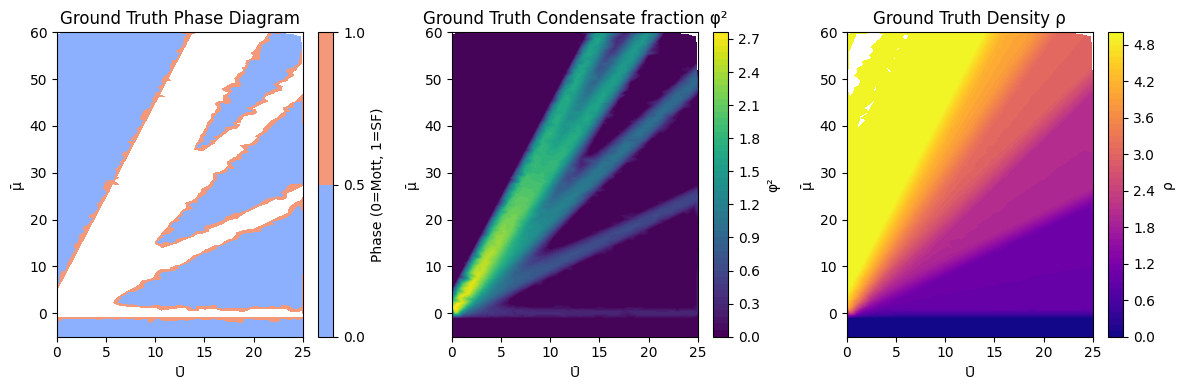

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 13.9906 - phase_accuracy: 0.5147 - phase_loss: 2.1472 - phi2_loss: 3.2424 - rho_loss: 8.4588 - val_loss: 3.5768 - val_phase_accuracy: 0.5405 - val_phase_loss: 0.6715 - val_phi2_loss: 0.0450 - val_rho_loss: 2.8378
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4757 - phase_accuracy: 0.5262 - phase_loss: 1.4615 - phi2_loss: 0.7109 - rho_loss: 6.2840 - val_loss: 3.5644 - val_phase_accuracy: 0.2020 - val_phase_loss: 1.2687 - val_phi2_loss: 0.0450 - val_rho_loss: 2.2414
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9931 - phase_accuracy: 0.5496 - phase_loss: 1.2402 - phi2_loss: 0.7153 - rho_loss: 5.0185 - val_loss: 3.1299 - val_phase_accuracy: 0.4211 - val_phase_loss: 0.9561 - val_phi2_loss: 0.0450 - val_rho_loss: 2.1176
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5235 - phase_accuracy: 0.5674 - phase_loss: 1.1060 - phi2_loss: 0.7113 - rho_loss: 3.6811 - val_loss: 2.7066 - val_phase_acc

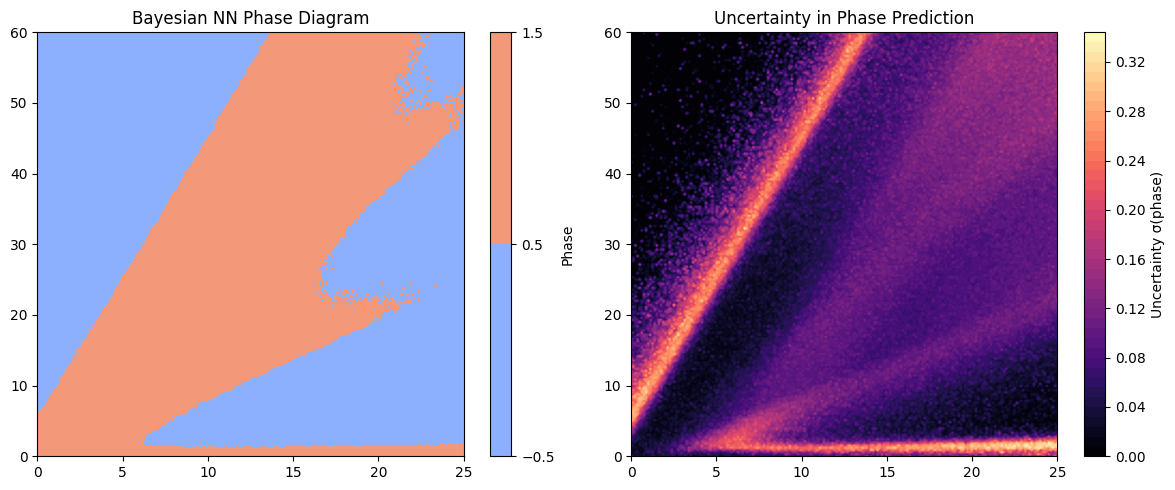

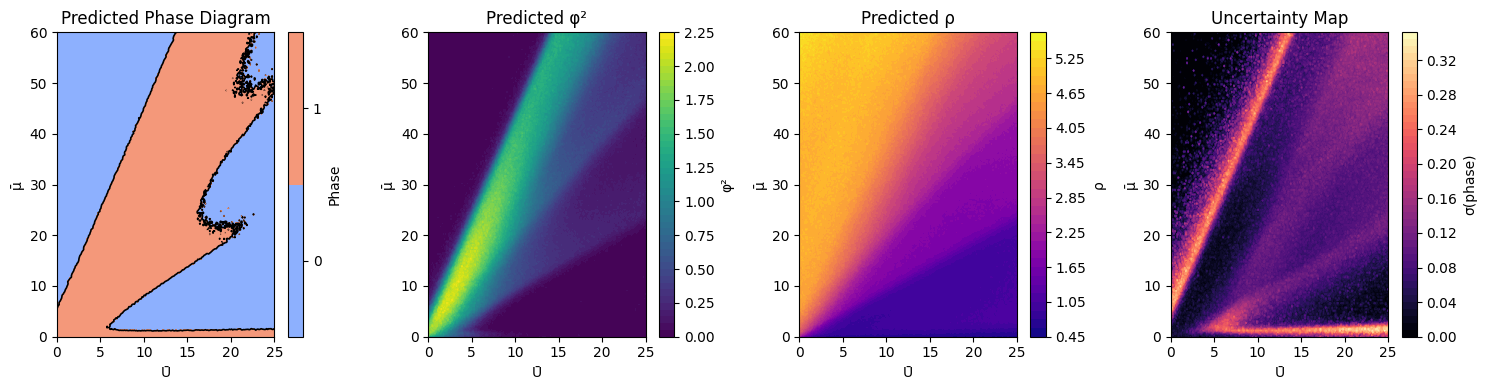

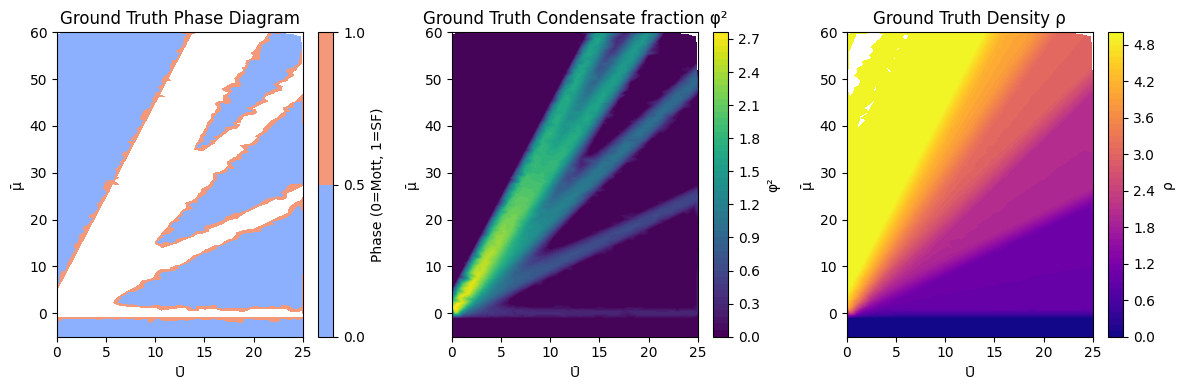


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.8318    0.8855    0.8578      2000
           1     0.9104    0.8666    0.8880      2684

    accuracy                         0.8747      4684
   macro avg     0.8711    0.8761    0.8729      4684
weighted avg     0.8768    0.8747    0.8751      4684



C:\Users\DELL\AppData\Local\Temp\ipykernel_13812\602815777.py:317: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)
print(df)

# # Features and targets
# X = df[["Ubar","Mubar"]].values.astype(np.float32)
# y = {
#     "phase": df["Phase"].values.astype(np.float32),
#     "phi2": df["Phi2"].values.astype(np.float32),
#     "rho": df["Density"].values.astype(np.float32),
# }
# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# # Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

# --- 1) Bayesian NN model ---
def make_bayesian_nn(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,), name="input")  # [Ū, M̄]
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # dropout active

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        metrics={"phase":"accuracy"}
    )
    return model

bayes_nn = make_bayesian_nn()

# --- 2) Train ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32),
}

history = bayes_nn.fit(
    X, y_targets,
    batch_size=256,
    epochs=100,
    validation_split=0.15,
    verbose=1
)

# --- 3) MC Dropout prediction ---
def mc_predict(model, X, n=50):
    preds_phase, preds_phi, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi, p_rho = model(X, training=True)  # keep dropout active
        preds_phase.append(p_phase.numpy())
        preds_phi.append(p_phi.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi, axis=0), np.std(preds_phi, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0)
    )

# --- 4) Phase diagram with uncertainty ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)

plt.figure(figsize=(12,5))

# Phase boundary
plt.subplot(1,2,1)
plt.contourf(UU, MU, (phase_mean>0.5).astype(int), levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(label="Phase")
plt.title("Bayesian NN Phase Diagram")

# Uncertainty map
plt.subplot(1,2,2)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="Uncertainty σ(phase)")
plt.title("Uncertainty in Phase Prediction")

plt.tight_layout()
plt.show()

# --- 4) Predict on grid with MC dropout ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict(bayes_nn, X_grid, n=50)

# Reshape
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)

phase_pred_class = (phase_mean > 0.5).astype(int)

# --- 5) Plot Bayesian NN predictions ---
plt.figure(figsize=(15,4))

# Phase
plt.subplot(1,4,1)
plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ²
plt.subplot(1,4,2)
plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ
plt.subplot(1,4,3)
plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Uncertainty
plt.subplot(1,4,4)
plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Uncertainty Map")

plt.tight_layout()
plt.show()


# --- 6) Ground truth (same as before) ---
plt.figure(figsize=(12,4))
# (phase, phi², rho from dataset)
# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# --- 7) Classification report on training data ---
from sklearn.metrics import classification_report

phase_train_mean, _, _, _, _, _ = mc_predict(bayes_nn, X, n=50)
y_pred_labels = (phase_train_mean > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


# PINN + bayesian

In [11]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# --- 1) Load dataset ---
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Phase label
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )


          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

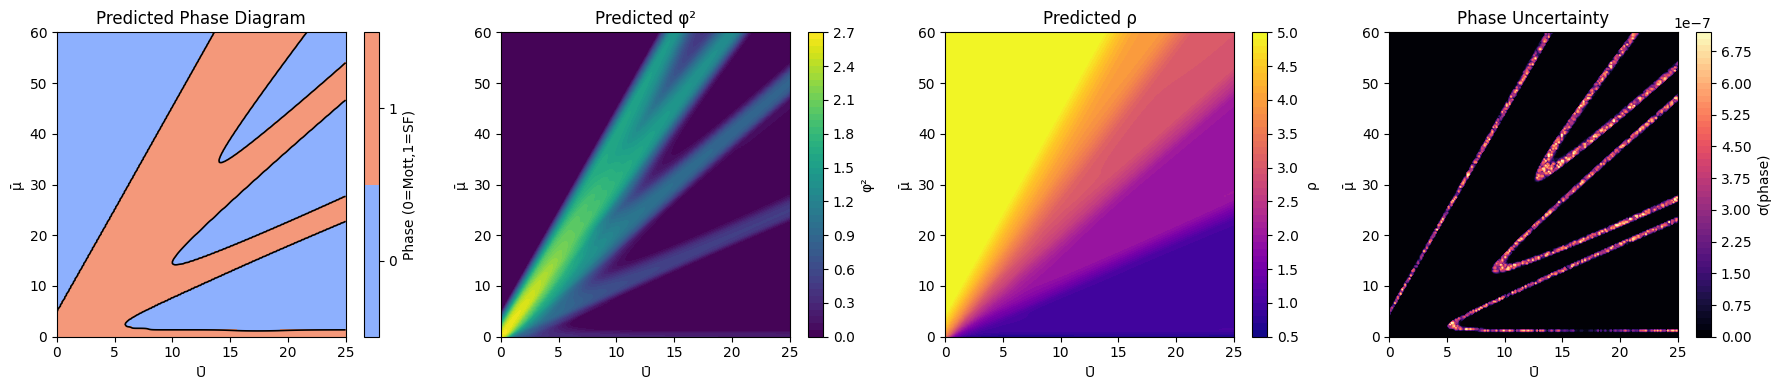

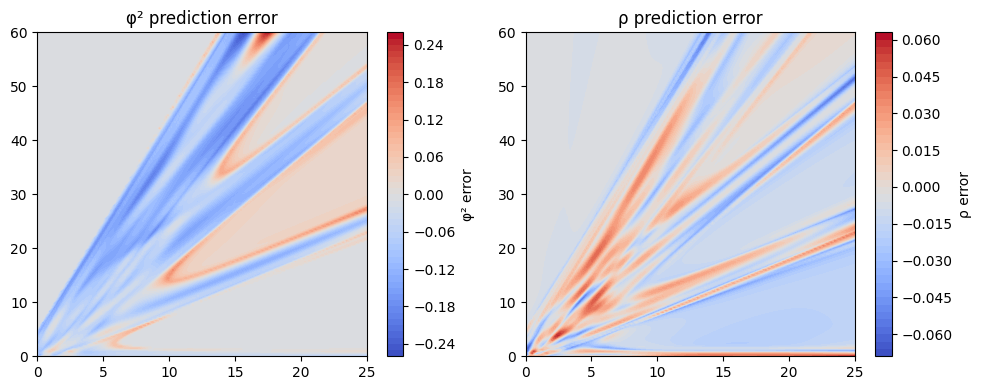

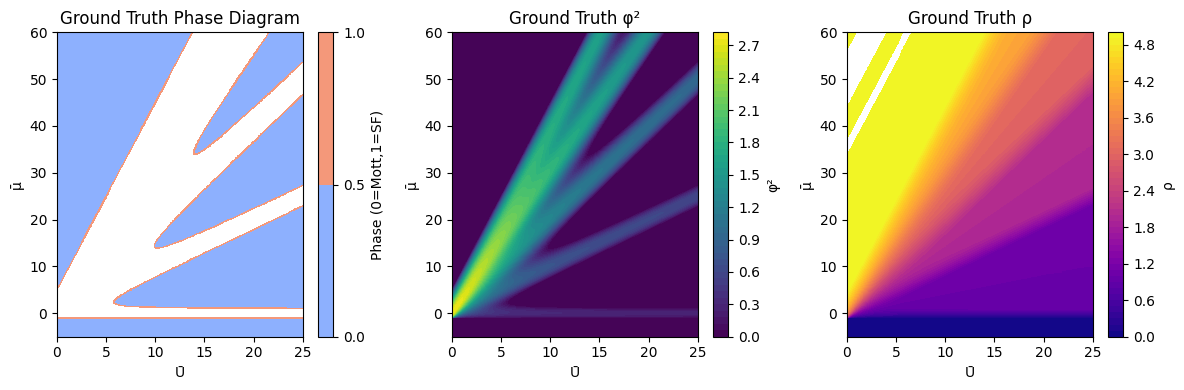


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9974    0.9868    0.9921     23172
           1     0.9821    0.9965    0.9893     16828

    accuracy                         0.9909     40000
   macro avg     0.9898    0.9917    0.9907     40000
weighted avg     0.9910    0.9909    0.9909     40000



In [14]:
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

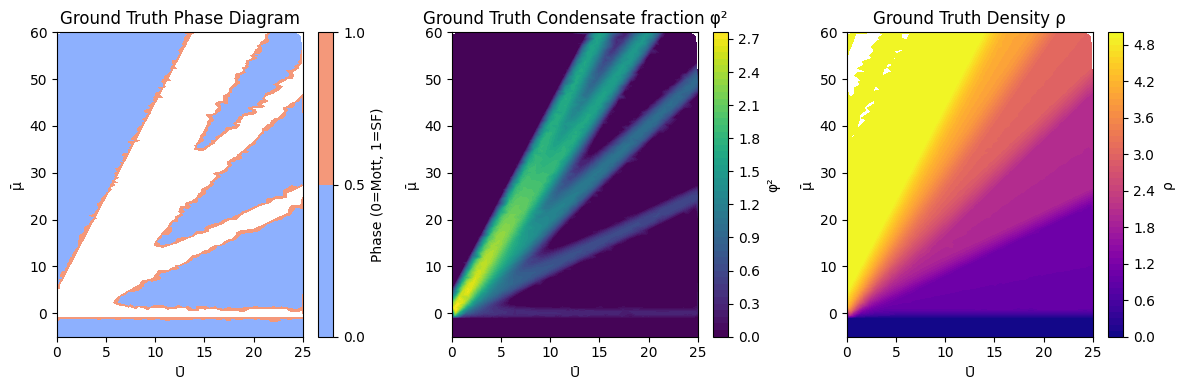

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 19.2647 - val_loss: 4.3253
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7511 - val_loss: 1.3326
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5864 - val_loss: 1.0098
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1697 - val_loss: 1.2623
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2955 - val_loss: 1.0417
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8056 - val_loss: 1.1373
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3894 - val_loss: 1.0866
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1111 - val_loss: 1.1341
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8938 - val_loss: 1.0900
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7158 - val_loss: 1.1480
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5816 - val_loss: 1.1084
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

In [15]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# --- 1) Load dataset ---
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Phase label
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(3000, len(df_MI))
n_SF = min(3000, len(df_SF))
n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )


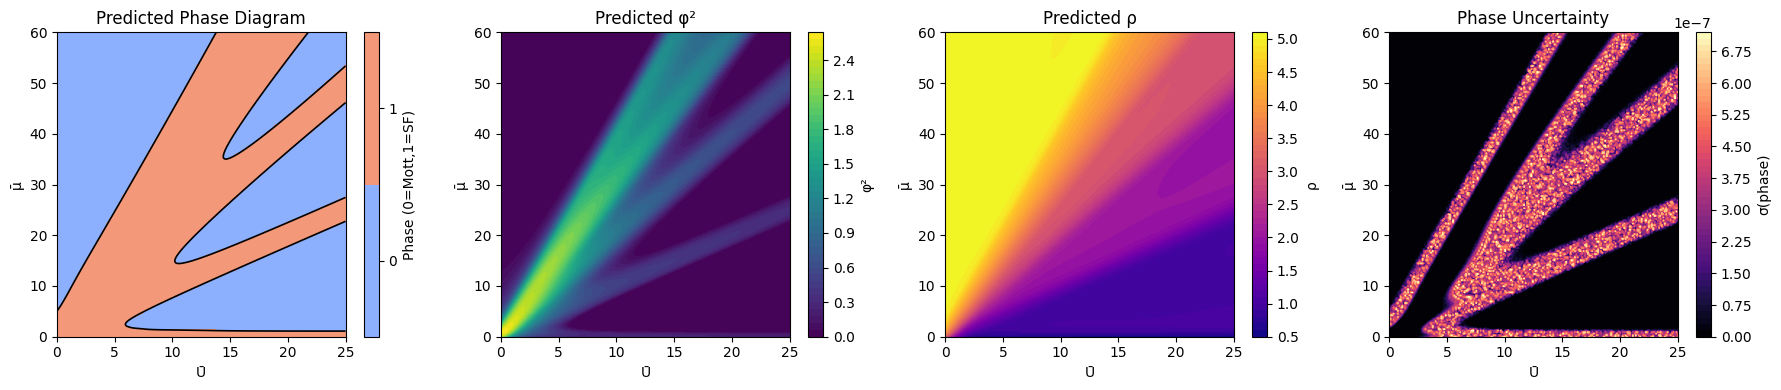

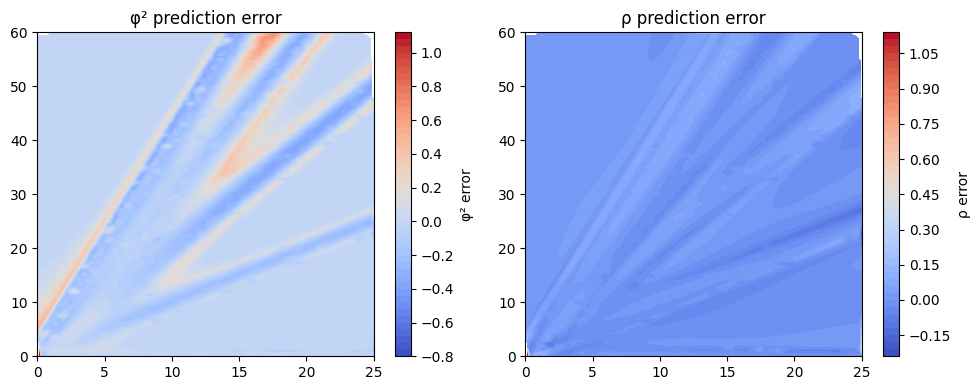

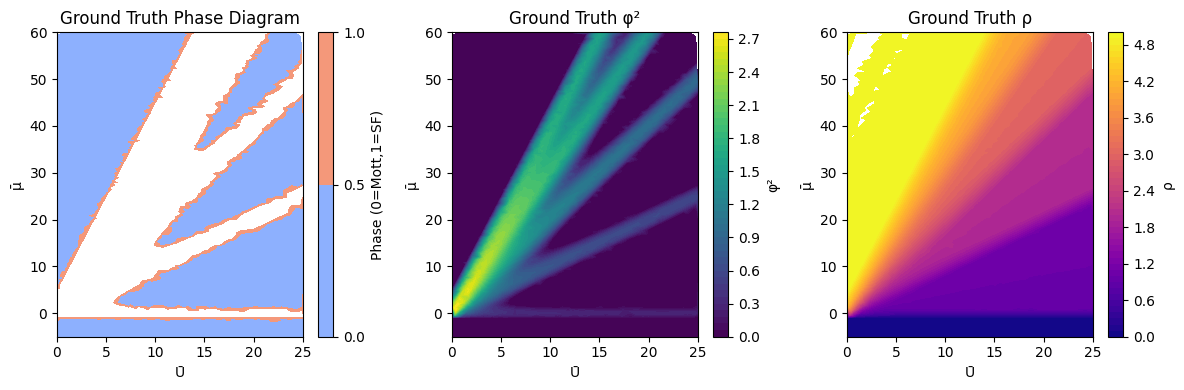


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9531    0.9936    0.9729     22256
           1     0.9915    0.9387    0.9644     17744

    accuracy                         0.9692     40000
   macro avg     0.9723    0.9662    0.9687     40000
weighted avg     0.9702    0.9692    0.9691     40000



In [16]:
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



## 4k

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

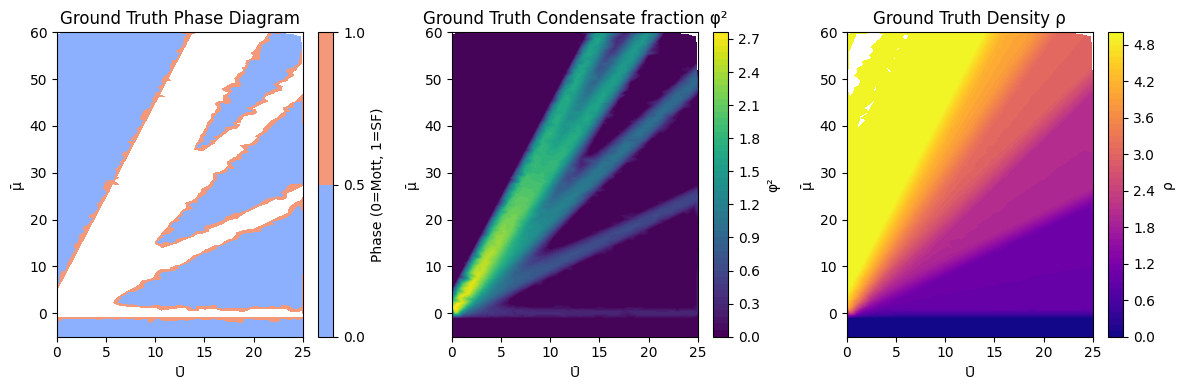

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.5596 - val_loss: 1.6444
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0551 - val_loss: 0.9701
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6188 - val_loss: 1.2522
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7409 - val_loss: 1.0928
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2660 - val_loss: 0.9738
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9386 - val_loss: 1.0005
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7445 - val_loss: 1.0266
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5917 - val_loss: 0.9696
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5141 - val_loss: 1.0429
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4862 - val_loss: 1.0529
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3961 - val_loss: 1.0031
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3777 - val_los

In [17]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# --- 1) Load dataset ---
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Phase label
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )


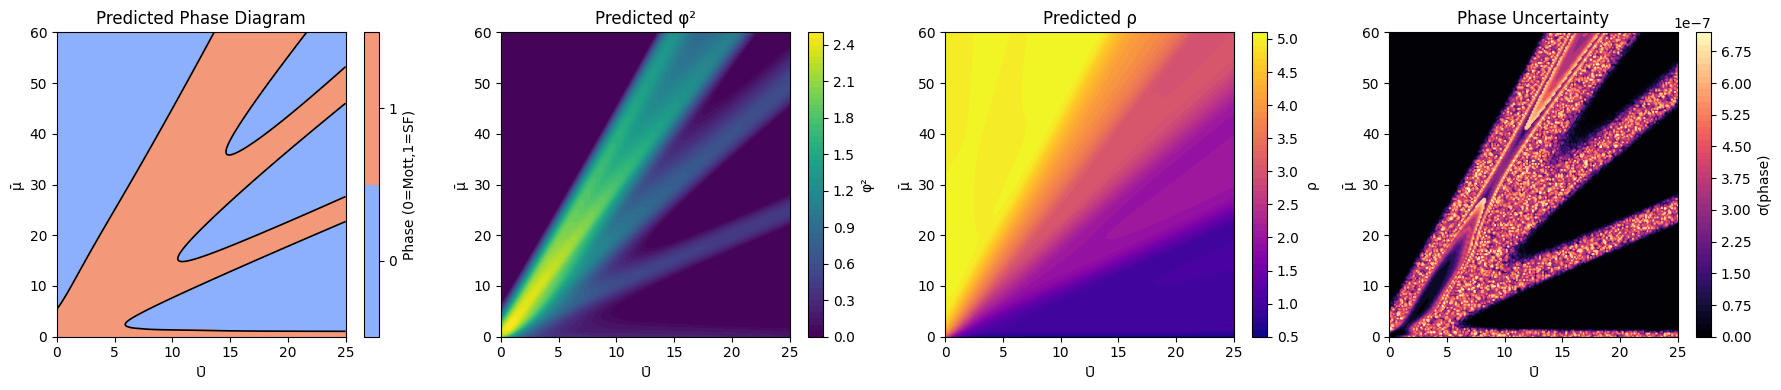

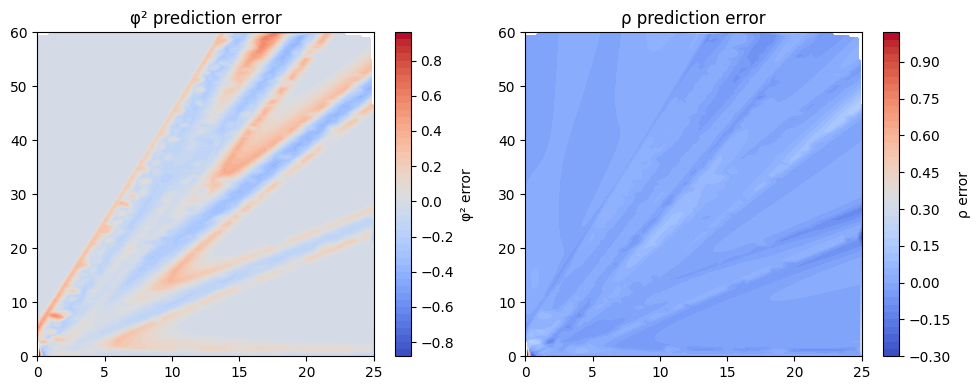

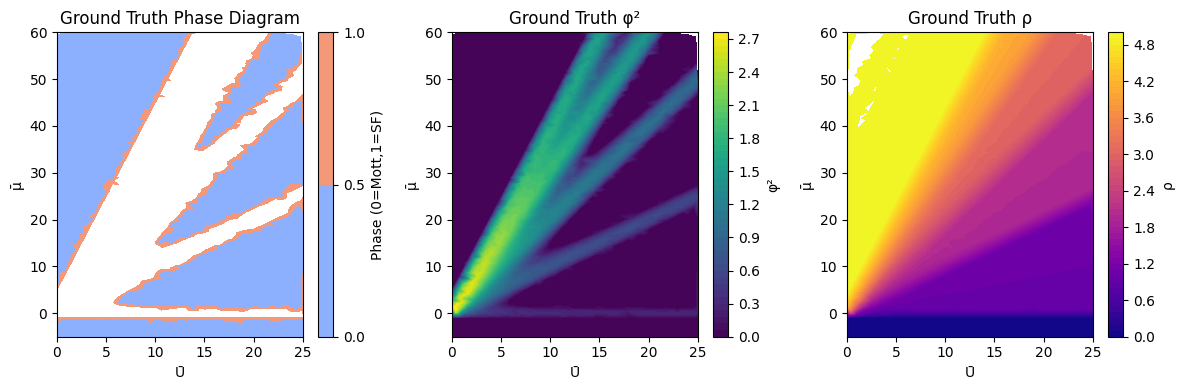


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9463    0.9932    0.9692     21976
           1     0.9911    0.9313    0.9603     18024

    accuracy                         0.9653     40000
   macro avg     0.9687    0.9622    0.9647     40000
weighted avg     0.9665    0.9653    0.9652     40000



In [18]:
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))



## 10k Dataset

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

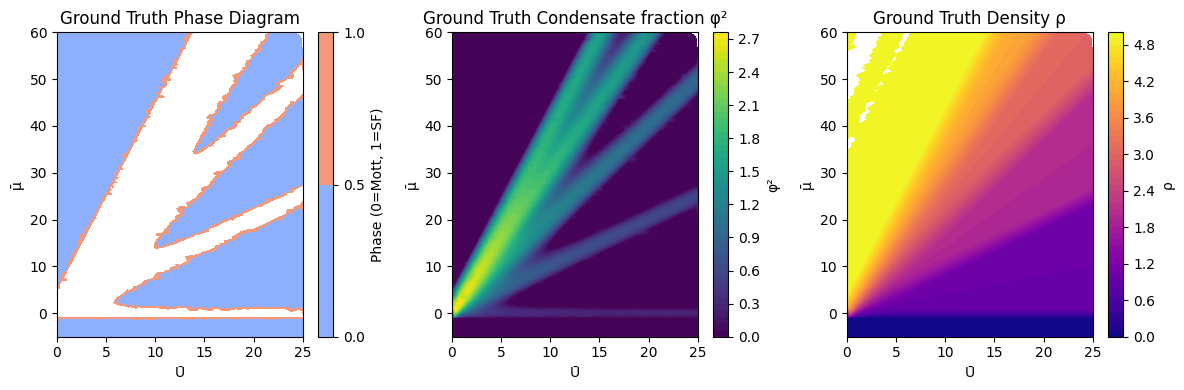

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.5650 - val_loss: 1.5803
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2470 - val_loss: 0.9712
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5267 - val_loss: 0.9790
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8808 - val_loss: 0.9949
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5049 - val_loss: 1.0392
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3027 - val_loss: 1.1514
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2161 - val_loss: 1.1430
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1282 - val_loss: 1.1371
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0617 - val_loss: 1.0672
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0377 - val_loss: 0.9692
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0014 - val_loss: 0.9662
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [19]:
# Callback to ramp lam_phys in model.loss via attribute; implement as example where model has attribute lam_phys
import tensorflow as tf

class LambdaRamp(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch, end_epoch, final_value):
        self.start = start_epoch
        self.end = end_epoch
        self.final = final_value
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.start:
            val = 0.0
        elif epoch >= self.end:
            val = self.final
        else:
            val = (epoch - self.start)/(self.end - self.start) * self.final
        # store in model for your physics loss lambda to read
        setattr(self.model, "lam_phys_current", float(val))
        # optional logging
        print(f"Epoch {epoch}: lam_phys_current={val:.6f}")

# Modify physics loss lambda in compile to read model.lam_phys_current; easiest: implement phys loss using closure that reads model attribute
# Example usage:
ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# pass ramp_cb to fit callbacks


import numpy as np, pandas as pd

# --- 1) Load dataset ---
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Phase label
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

print(df)



# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# # Load dataset
# df = reduced_df

print(df)

df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(5000, len(df_MI))
n_SF = min(5000, len(df_SF))
n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# 1) Bayesian surrogate (with dropout active)
def build_bayesian_surrogate(hidden=(128,64), dropout_rate=0.2):
    inp = keras.Input(shape=(2,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x, training=True)  # key: active dropout
    out = layers.Dense(2, activation="linear")(x)  # [phi2, rho]
    return keras.Model(inp, out)

# bayes_surrogate = build_bayesian_surrogate()
# bayes_surrogate.compile(optimizer="adam", loss="mse")

X_surr = df[["Ubar","Mubar"]].values.astype(np.float32)
y_surr = df[["Phi2","Density"]].values.astype(np.float32)

# surrogate = build_surrogate()
# surrogate.fit(
#     X_surr, y_surr,
#     epochs=200, batch_size=512,
#     validation_split=0.15, verbose=1
# )

bayes_surrogate = build_bayesian_surrogate()
bayes_surrogate.compile(optimizer="adam", loss="mse")
# Train Bayesian surrogate
bayes_surrogate.fit(X_surr, y_surr, epochs=200, batch_size=512,
                    validation_split=0.15, verbose=1)

bayes_surrogate.trainable = False

# 2) PINN with Bayesian surrogate in physics residual
def make_pinn_with_bayesian_surrogate(hidden=(128,64), lam_phase=1.0, lam_phys=1.0):
    inp = keras.Input(shape=(2,), name="input")   # [Ubar, Mubar]
    lam_phys_var = tf.Variable(lam_phys, trainable=False, dtype=tf.float32, name="lam_phys")
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="tanh")(x)

    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="relu", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="relu", name="rho")(x)

    # Physics residual (using dropout surrogate)
    def phys_residual(inputs):
        UMb, phi_pred = inputs
        s = bayes_surrogate(UMb, training=True)     # Bayesian surrogate (dropout ON)
        s_phi = tf.expand_dims(s[:,0], -1)
        return phi_pred - s_phi

    phys_out = layers.Lambda(lambda t: phys_residual(t), name="phys_res")([inp, phi_out])

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out, phys_out])

    losses = {
        "phase": "binary_crossentropy",
        "phi2": "mse",
        "rho": "mse",
        "phys_res": lambda y_true, y_pred: lam_phys_var * tf.reduce_mean(tf.square(y_pred))
    }
    loss_weights = {"phase": lam_phase, "phi2": 1.0, "rho": 1.0, "phys_res": 1.0}

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=losses,
        loss_weights=loss_weights,
        metrics={"phase":"accuracy"}
    )
    model.lam_phys = lam_phys_var
    return model

pinn_bnn = make_pinn_with_bayesian_surrogate()

# 3) Train PINN-BNN
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1),
    "phi2":  df["Phi2"].values.reshape(-1,1),
    "rho":   df["Density"].values.reshape(-1,1),
    "phys_res": np.zeros((len(df),1))
}

ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
pinn_bnn.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[ramp_cb]
)

# 4) MC Prediction (PINN + Bayesian surrogate uncertainty)
def mc_predict_pinn(model, X, n=50):
    preds_phase, preds_phi2, preds_rho = [], [], []
    for _ in range(n):
        p_phase, p_phi2, p_rho, _ = model(X, training=True)
        preds_phase.append(p_phase.numpy())
        preds_phi2.append(p_phi2.numpy())
        preds_rho.append(p_rho.numpy())
    return (
        np.mean(preds_phase, axis=0), np.std(preds_phase, axis=0),
        np.mean(preds_phi2, axis=0), np.std(preds_phi2, axis=0),
        np.mean(preds_rho, axis=0), np.std(preds_rho, axis=0),
    )

# ramp_cb = LambdaRamp(start_epoch=5, end_epoch=40, final_value=1.0)
# history = pinn_surrogate.fit(
#     X, y_targets,
#     batch_size=256,
#     epochs=200,
#     validation_split=0.15,
#     callbacks=[
#         keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),ramp_cb
#         # keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
#     ]
# )


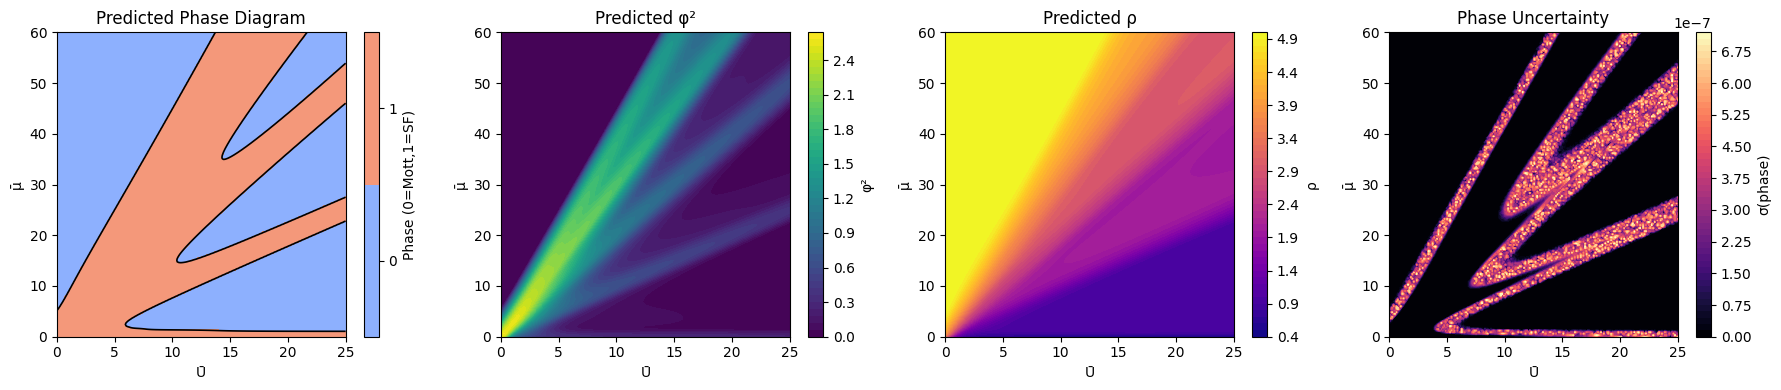

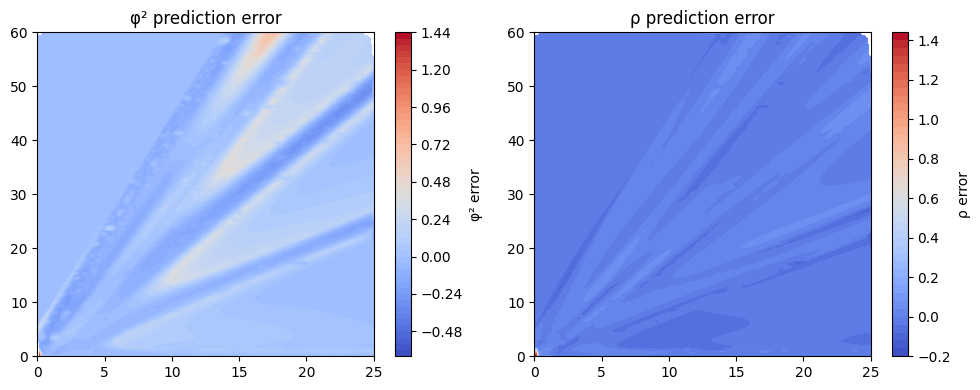

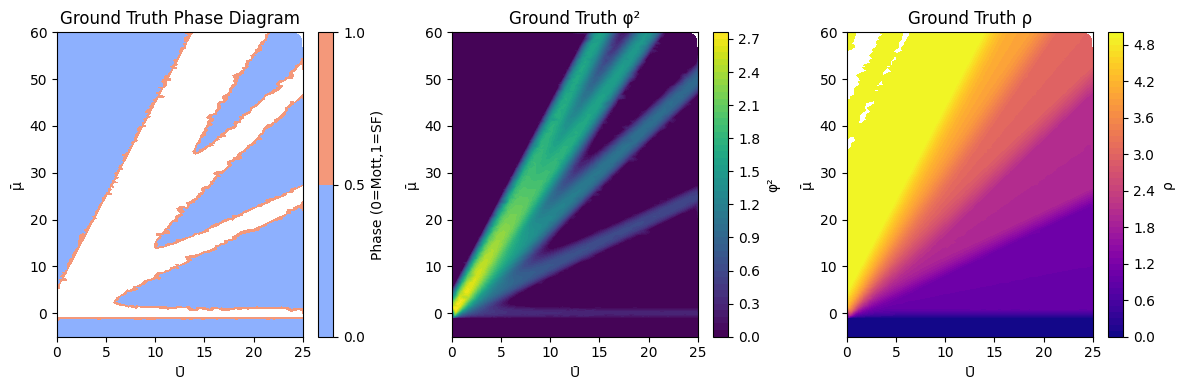


📊 Classification Report (Phase, PINN + Bayesian, Grid):
              precision    recall  f1-score   support

           0     0.9772    0.9890    0.9831     22564
           1     0.9856    0.9701    0.9778     17436

    accuracy                         0.9808     40000
   macro avg     0.9814    0.9796    0.9804     40000
weighted avg     0.9808    0.9808    0.9808     40000



In [20]:
# --- 5) Phase diagram prediction (PINN + Bayesian surrogate) ---
U_vals = np.linspace(0, 25, 200)   # Ū axis
mu_vals = np.linspace(0, 60, 200)  # μ̄ axis
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

# MC prediction over N passes
phase_mean, phase_std, phi2_mean, phi2_std, rho_mean, rho_std = mc_predict_pinn(pinn_bnn, X_grid, n=50)

# Reshape to grid
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_mean = phase_mean.reshape(UU.shape)
phase_std  = phase_std.reshape(UU.shape)
phi2_mean  = phi2_mean.reshape(UU.shape)
rho_mean   = rho_mean.reshape(UU.shape)


# --- reshape outputs properly ---
phase_pred_class = (phase_mean > 0.5).astype(int)
phase_pred_class = phase_pred_class.reshape(UU.shape)  # <-- important fix

# --- Plot predicted phase, φ², ρ and uncertainty ---
plt.figure(figsize=(18,4))

# Phase diagram
plt.subplot(1,4,1)
mappable = plt.contourf(UU, MU, phase_pred_class, levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase (0=Mott,1=SF)")
plt.contour(UU, MU, phase_mean, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted Phase Diagram")

# φ² diagram
plt.subplot(1,4,2)
mappable = plt.contourf(UU, MU, phi2_mean, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted φ²")

# ρ diagram
plt.subplot(1,4,3)
mappable = plt.contourf(UU, MU, rho_mean, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Predicted ρ")

# Phase uncertainty
plt.subplot(1,4,4)
mappable = plt.contourf(UU, MU, phase_std, 50, cmap="magma")
plt.colorbar(mappable, label="σ(phase)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Uncertainty")
plt.tight_layout(); plt.show()

# --- Compute errors on grid ---
from scipy.interpolate import griddata
points = df[["Ubar","Mubar"]].values
phi2_true_interp = griddata(points, df["Phi2"].values, (UU, MU), method="linear")
rho_true_interp  = griddata(points, df["Density"].values, (UU, MU), method="linear")

phi2_err = phi2_mean - phi2_true_interp
rho_err  = rho_mean - rho_true_interp

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(UU, MU, phi2_err, 50, cmap="coolwarm")
plt.colorbar(label="φ² error")
plt.title("φ² prediction error")

plt.subplot(1,2,2)
plt.contourf(UU, MU, rho_err, 50, cmap="coolwarm")
plt.colorbar(label="ρ error")
plt.title("ρ prediction error")
plt.tight_layout(); plt.show()

# --- Ground truth for comparison ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm")
plt.colorbar(label="Phase (0=Mott,1=SF)")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth Phase Diagram")

plt.subplot(1,3,2)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis")
plt.colorbar(label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth φ²")

plt.subplot(1,3,3)
plt.tricontourf(df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma")
plt.colorbar(label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Ground Truth ρ")
plt.tight_layout(); plt.show()

# # --- Classification report on training data ---
# y_pred_labels = (phase_mean.ravel() > 0.5).astype(int)
# y_true_labels = df["Phase"].astype(int).ravel()

# from sklearn.metrics import classification_report
# print("\n📊 Classification Report (Phase, PINN + Bayesian):")
# print(classification_report(y_true_labels, y_pred_labels, digits=4))
from scipy.interpolate import griddata

phase_true_grid = griddata(
    df[["Ubar","Mubar"]].values, 
    df["Phase"].values, 
    (UU, MU), 
    method="linear"
)

y_true_labels_grid = (phase_true_grid.ravel() > 0.5).astype(int)
y_pred_labels_grid = phase_pred_class.ravel()

from sklearn.metrics import classification_report
print("\n📊 Classification Report (Phase, PINN + Bayesian, Grid):")
print(classification_report(y_true_labels_grid, y_pred_labels_grid, digits=4))

